This is a program which is in testing phase. We will use a linear regression ML model to give an SOC number for the flights.

In [1]:
# Import the querying module
from flight_querying import query_flights
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Set up and retrieve the data from the database.
db_connect = query_flights()

In [2]:
# Make the data dictionary holder
data_dict = {
    "Time Delta": [],
    "SOC Delta": [],
    "Activity": [],
    "Average Power": [],
    "Id": [],
    "Unique Data Identifier": [],
    "temperature": [],
    "Visibility": [],
    "Wind Speed": []
}

# Create a increasing int variable to keep track of the Unique Data Identifier
unique_identifier = 0

In [3]:
def data_parser(parsing_dataframe):

    global unique_identifier

    # Get the current exercise
    current_exercise = parsing_dataframe.iloc[0, parsing_dataframe.columns.get_loc('activity')]
    id = parsing_dataframe.iloc[0, parsing_dataframe.columns.get_loc('id')]
    max_soc, min_soc = 0, 101
    power_list = [0]
    min_time, max_time = 100, 0

    # iterate over all the rows
    for index, row in parsing_dataframe.iterrows():

        # Get the data needed from the rows. Append the power
        new_exercise = row["activity"]
        soc = row["soc"]
        power_list.append(row["power"])
        time = row["time"]
        outside_temp = row["temperature"]
        visibility = row["visibility"]
        wind_speed = row["wind_speed"]

        # If the exercise changes or if the rows end.
        if current_exercise != new_exercise or index == len(parsing_dataframe) - 1:

            # Set the values 
            data_dict["Time Delta"].append(round(max_time - min_time, 2))
            data_dict["SOC Delta"].append(max_soc - min_soc)
            data_dict["Activity"].append(current_exercise)
            data_dict["Average Power"].append(round(sum(power_list)/len(power_list), 2))
            data_dict["temperature"].append(outside_temp)
            data_dict["Visibility"].append(visibility)
            data_dict["Wind Speed"].append(wind_speed)
            data_dict["Id"].append(id)
            data_dict["Unique Data Identifier"].append(unique_identifier)
            unique_identifier = unique_identifier + 1

            # Reset all the values
            max_soc, min_soc = soc, soc
            power_list.clear()
            max_time, min_time = time, time
        
        # SOC
        if soc >= max_soc:
            max_soc = soc
        if soc <= min_soc:
            min_soc = soc

        # TIME
        if time >= max_time:
            max_time = time
        if time <= min_time:
            min_time = time
        
        # Change current exercise
        current_exercise = new_exercise


In [4]:
# Flight IDs to include
flight_ids = [4620, 4929, 4940, 5019, 5021, 5034]

# Fetch data for specified flight IDs
# Remove NA values from each dataframe in the list and put it through the data parser
for ids in flight_ids:
    frame = db_connect.connect_flight_for_ml_data_prescription(ids)
    frame = frame[frame["activity"] != "NA"].reset_index()
    data_parser(frame)

# Concatenate data frames and shuffle the data
# all_data = pd.concat(data_frames, axis=0).sample(frac=1, random_state=42)
all_data = pd.DataFrame(data_dict)

In [5]:
# Split the data into train and test sets
train_data, test_data = train_test_split(all_data, test_size=0.3, random_state=42)

In [6]:
all_data.head()

,Time Delta,SOC Delta,Activity,Average Power,Id,Unique Data Identifier,temperature,Visibility,Wind Speed
0,0.98,3.166667,takeoff,52.62,4620,0,66.2,9.0,4
1,0.88,3.500000,climb,51.16,4620,1,64.4,9.0,6
2,1.28,2.000000,cruise,14.82,4620,2,66.2,9.0,4
3,1.18,0.000000,landing,0.69,4620,3,66.2,9.0,4
4,0.68,2.041667,takeoff,52.72,4620,4,64.4,9.0,6


In [7]:
print(f"Length train_x = {len(train_data)} \n Length train_y = {len(test_data)}")

Length train_x = 67 
 Length train_y = 29


One-Hot-Encoding of the Operations columns

In [8]:
# ONE-HOT ENCODE
# https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
def one_hot(df, col, pre):
  encoded = pd.get_dummies(df[col], prefix=pre)
  for column in encoded:
    encoded = encoded.rename(columns={column: col + "_" + column})
  encoded['Unique Data Identifier'] = df['Unique Data Identifier']
  return encoded

In [9]:
# Encode Train data
train_encoded = one_hot(train_data, "Activity", 'is')
final_train_x = pd.merge(train_data, train_encoded, on=["Unique Data Identifier"])
final_train_y = final_train_x["SOC Delta"].to_numpy()
final_train_x = final_train_x.drop(columns=["SOC Delta", "Id", "Unique Data Identifier", "Activity"])

# Encode Test data
test_encoded = one_hot(test_data, "Activity", 'is')
final_test_x = pd.merge(test_data, test_encoded, on=["Unique Data Identifier"])
final_test_y = final_test_x["SOC Delta"].to_numpy()
final_test_x = final_test_x.drop(columns=["SOC Delta", "Id", "Unique Data Identifier", "Activity"])

In [10]:
final_train_x

,Time Delta,Average Power,temperature,Visibility,Wind Speed,Activity_is_climb,Activity_is_cruise,Activity_is_descent,Activity_is_landing,Activity_is_power off stall,Activity_is_power on stall,Activity_is_slow flight,Activity_is_steep turns,Activity_is_takeoff
0,0.68,29.23,44.6,9.0,2,False,False,False,False,False,False,False,True,False
1,2.28,43.18,51.8,5.0,2,True,False,False,False,False,False,False,False,False
2,1.08,44.37,53.6,9.0,7,True,False,False,False,False,False,False,False,False
3,0.78,0.23,53.6,9.0,7,False,False,True,False,False,False,False,False,False
4,0.98,43.69,64.4,9.0,6,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.68,43.82,44.6,9.0,3,True,False,False,False,False,False,False,False,False
63,3.38,17.87,48.2,9.0,3,False,False,False,False,False,False,True,False,False
64,1.48,20.15,66.2,9.0,4,False,True,False,False,False,False,False,False,False
65,0.68,53.64,55.4,9.0,9,False,False,False,False,False,False,False,False,True


In [11]:
print(f"Length test_encoded = {len(test_encoded)} \n Length train_encoded = {len(train_encoded)}")

Length test_encoded = 29 
 Length train_encoded = 67


In [12]:
print(f"Length train_x = {len(final_train_x)} \n Length train_y = {len(final_train_y)}")

Length train_x = 67 
 Length train_y = 67


In [13]:
print(f"Length test_x = {len(final_test_x)} \n Length test_y = {len(final_test_y)}")

Length test_x = 29 
 Length test_y = 29


Machine Learning Model Implementation

In [14]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Set model
ridge_model = Ridge(alpha=0.9)  # You can adjust the alpha parameter for regularization strength

# Fit model
ridge_model.fit(final_train_x, final_train_y)

# Make predictions
ridge_predictions = ridge_model.predict(final_test_x)

# Evaluate the model
mse = mean_squared_error(final_test_y, ridge_predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 3.5511334287343703


In [15]:
# Make predictions using the testing set
y_pred = ridge_model.predict(final_test_x)

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error

# Mean Squared Error (MSE)
mse = mean_squared_error(final_test_y, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Coefficient of Determination (R-squared)
r_squared = r2_score(final_test_y, y_pred)
print(f'Coefficient of Determination (R-squared): {r_squared}')

# K-fold Cross-Validation for R-squared
cross_val_r_squared = cross_val_score(ridge_model, final_train_x, final_train_y, cv=5, scoring='r2')
print(f'Cross-validated R-squared: {np.mean(cross_val_r_squared)}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(final_test_y, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(final_test_y, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds (k)
num_folds = 5  # You can adjust this based on your preference

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation for R-squared
cross_val_r_squared = cross_val_score(ridge_model, final_train_x, final_train_y, cv=kf, scoring='r2')

# Display the results
print(f'K-fold Cross-validated R-squared: {np.mean(cross_val_r_squared)}')


Mean Squared Error (MSE): 3.5511334287343703
Coefficient of Determination (R-squared): 0.7189718971196786
Cross-validated R-squared: 0.8456738878798389
Mean Absolute Error (MAE): 1.0291204637327613
Root Mean Squared Error (RMSE): 1.8844451248933651
K-fold Cross-validated R-squared: 0.7988754417154982


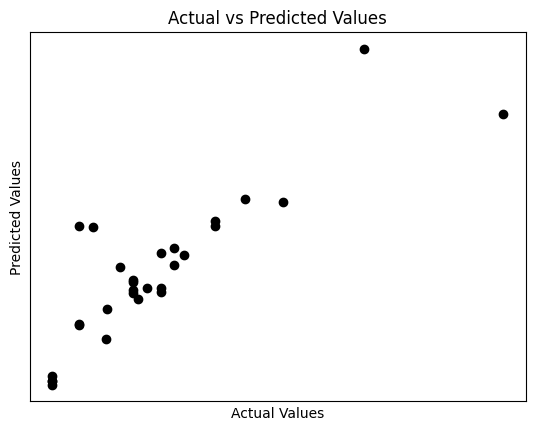

In [18]:
import matplotlib.pyplot as plt

# Plot outputs
plt.scatter(final_test_y, y_pred, color="black")

plt.xticks(())
plt.yticks(())

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

plt.show()

In [19]:
coeff = pd.DataFrame(list(zip(ridge_model.feature_names_in_, ridge_model.coef_)), columns = ['Feature', 'Weight'])
coeff.sort_values('Weight')

,Feature,Weight
13,Activity_is_takeoff,-1.045629
8,Activity_is_landing,-0.982461
3,Visibility,-0.469568
7,Activity_is_descent,-0.468753
10,Activity_is_power on stall,-0.269134
2,temperature,-0.011148
4,Wind Speed,0.035042
11,Activity_is_slow flight,0.051950
1,Average Power,0.070858
9,Activity_is_power off stall,0.422200
